In [38]:
from __future__ import print_function
import numpy as np
import pandas as pd

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [39]:
import pymc3 as pm
import theano
import theano.tensor as T
from scipy.stats.stats import pearsonr

import sklearn.model_selection

In [40]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [41]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

To recap, variables of interest include: 

+ Echo parameters (LV systolic, RV size, pulmonary hypertension)
+ Fluids (day 1: missing term = 1 only if missing on day 1, day1-2: missing term = 1 if missing on day 1 or 2, day1-3: missing term = 1 if missing on day 1, day 2 or day 3)
+ Interactions: fluids x echo variables, fluids x CHF, echo x CHF
+ Covariates: Age, gender, BMI, BMI missing, mech vent, CHF, MDRD, Cr missing, apache score, lactate, lactate missing, ICU type, pressors indicator variable

In [42]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,ethnicity,insurance,filter_vaso,...,pc_bronch,pc_cath,pc_echo,pc_pressor,pc_rhc,pc_thora,pc_vent,passed_filters,use_record,bmi
0,200001,152234,55973,22290 days 19:06:12,F,167.851667,27.669135,ASIAN - ASIAN INDIAN,Medicare,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9.820741
1,200003,163557,27513,17625 days 19:50:04,M,177.800000,78.224998,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.744692
2,200006,189514,10950,19736 days 11:28:14,M,165.100000,82.400002,OTHER,Medicaid,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.229647
3,200007,129310,20707,15818 days 10:03:37,M,177.800000,126.000000,WHITE,Private,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.857223
4,200009,129607,29904,17353 days 10:34:32,F,160.020000,85.833331,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.520264


In [43]:
len(ef)

61532

In [44]:
use_record = (ef['use_record'] == 1)
has_echo = ~ef['ea_key'].isnull()
F = use_record & has_echo

In [45]:
ef = ef.loc[F]
len(ef)

3686

In [46]:
import statsmodels.api as sm

# Preprocessing

## Add MDRD to table

In [47]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [48]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    905
1    783
2    597
4    579
3    518
5    246
dtype: int64

## Build dataframe

In [49]:
def normalize(x):
    x = x.copy()
    I = ~np.isnan(x)
    x[I] = (x[I] - x[I].mean())/x[I].std()
    return x

In [50]:
X = pd.DataFrame()

# build the features table
age = ef.age/np.timedelta64('1', 'Y') # time in years
age_masked = age < 0 # if age is less than 0, then the person is above 89 (90?)
age = normalize(age)
age[age_masked] = 0
X['age'] = age
X['age_over_90'] = age_masked.astype(float)

gender = ef.gender
gender = (gender == 'F').astype(float)
X['gender'] = gender

bmi = ef.bmi
bmi_missing = np.isnan(bmi)
bmi = normalize(bmi)
bmi[bmi_missing] = 0
X['bmi'] = bmi
X['bmi_missing'] = bmi_missing.astype(float)

mech_vent = ef.vf_first_day_vent.astype(float)
X['mech_vent'] = mech_vent

chf = ef.ex_congestive_heart_failure.astype(float)
X['CHF'] = chf

mdrd = ef.mdrd
mdrd_missing = np.isnan(mdrd)
mdrd = normalize(mdrd)
mdrd[mdrd_missing] = 0
X['mdrd'] = mdrd

# MDRD missing is already largely covered by BMI missing
# the only other missing values come from missing creatinine lab
# so add that
creatinine_missing = np.isnan(ef.lab_creatinine)
X['creatinine_missing'] = creatinine_missing.astype(float)

apsiii = ef.apsiii
#apsiii_missing = np.isnan(apsiii)
apsiii = normalize(apsiii)
#apsiii[apsiii_missing] = 0
X['apsiii'] = apsiii
#X['apsiii_missing'] = apsiii_missing.astype(float)

no_echo = np.isnan(ef.ea_key)
#X['no_echo'] = no_echo.astype(float)

# -3 cannot assess
# -2 ?depressed
# -1 hyper
# 0 normal
# 1 mildly depressed
# 2 moderately depressed
# 3 severe
lvsys = ef.ea_lv_systolic
lv_missing = (((np.isnan(lvsys)) | (lvsys < -2)) & ~no_echo).astype(float)
lv_hyperdynamic = (lvsys == -1).astype(float)
lv_normal = (lvsys == 0).astype(float)
lv_mild = (lvsys == 1).astype(float)
lv_depressed = ((lvsys == 2) | (lvsys == -2)).astype(float)
lv_sev_depressed = (lvsys == 3).astype(float)
X['lv_missing'] = lv_missing
X['lv_normal'] = lv_normal
X['lv_mild'] = lv_mild
X['lv_hyper'] = lv_hyperdynamic
X['lv_depressed'] = lv_depressed
X['lv_severe'] = lv_sev_depressed

# -3 cannot assess
# -2 PA systolic hypertension
# 0 normal
# 1 mild
# 2 moderate
# 3 severe
tvpulm = ef.ea_tv_pulm_htn
tv_missing = (((np.isnan(tvpulm)) | (tvpulm < -2)) & ~no_echo).astype(float)
tv_normal = (tvpulm == 0).astype(float)
tv_abnormal = ((tvpulm == -2) | (tvpulm > 0)).astype(float)
X['plm_htn_missing'] = tv_missing
X['plm_htn_normal'] = tv_normal
X['plm_htn_abnormal'] = tv_abnormal

# -3 cannot assess 
# -2 dilated
# -1 small
# 0 normal
# 1 mildly dilated
# 2 moderately dilated
rvcavity = ef.ea_rv_cavity
rvcav_missing = (((np.isnan(rvcavity) | (rvcavity < -2))) & ~no_echo).astype(float)
rvcav_normal = (rvcavity == 0).astype(float)
rvcav_small = (rvcavity == -1).astype(float)
rvcav_dilated = ((rvcavity == -2) | (rvcavity > 0)).astype(float)
X['rvcav_missing'] = rvcav_missing
X['rvcav_normal'] = rvcav_normal
X['rvcav_small'] = rvcav_small
X['rvcav_dilated'] = rvcav_dilated

lactate = ef.lab_lactate
lactate_missing = np.isnan(lactate)
lactate = normalize(lactate)
lactate[lactate_missing] = 0
X['lactate'] = lactate
X['lactate_missing'] = lactate_missing.astype(float)

## which ICU was treating the patient
sicu = ef.st_sicu.astype(float)
sicu[np.isnan(sicu)] = 0
nsicu = ef.st_nsicu.astype(float)
nsicu[np.isnan(nsicu)] = 0
micu = ef.st_micu.astype(float)
micu[np.isnan(micu)] = 0
#X['sicu'] = sicu
#X['nsicu'] = nsicu
X['micu'] = micu

## on vasopressors
on_vaso = ef.filter_vaso.astype(float)
X['on_vaso'] = on_vaso

## fluids
fluid_day1 = ef.fb_day1_balance_ml.values
f1_missing = np.isnan(fluid_day1)
fluid_day1[~f1_missing] = normalize(fluid_day1[~f1_missing])
fluid_day1[f1_missing] = 0
X['fluid_day1'] = fluid_day1
X['fluid_day1_missing'] = f1_missing.astype(float)

fluid_day2 = ef.fb_day2_balance_ml.values
f2_missing = np.isnan(fluid_day1) | np.isnan(fluid_day2)
fluid_day2[~f2_missing] = normalize(fluid_day2[~f2_missing])
fluid_day2[f2_missing] = 0
X['fluid_day2'] = fluid_day2
X['fluid_day2_missing'] = f2_missing.astype(float)

fluid_day3 = ef.fb_day3_balance_ml.values
f3_missing = np.isnan(fluid_day1) | np.isnan(fluid_day2) | np.isnan(fluid_day3)
fluid_day3[~f3_missing] = normalize(fluid_day3[~f3_missing])
fluid_day3[f3_missing] = 0
X['fluid_day3'] = fluid_day3
X['fluid_day3_missing'] = f3_missing.astype(float)

y = (ef.dod - ef.intime) < np.timedelta64(30, 'D')

X.shape, y.shape

((3686, 33), (3686,))

In [51]:
f1_missing.sum(), f2_missing.sum(), f3_missing.sum()

(215, 453, 925)

In [52]:
store = pd.HDFStore("../data/170525_statsmodels_echo_GY.h5")
store['X'] = X
store['y'] = y
store.close()

## Define model features

In [53]:
echo_features = {
    'lv': ['lv_missing', 'lv_mild', 'lv_hyper', 'lv_depressed', 'lv_severe'], 
    'plm_htn': ['plm_htn_missing', 'plm_htn_abnormal'], 
    'rvcav': ['rvcav_missing', 'rvcav_small', 'rvcav_dilated'], 
}
echo_features['all'] = echo_features['lv'] + echo_features['plm_htn'] + echo_features['rvcav']

fluid_features = {
    'fluid_day1': ['fluid_day1'], 
    'fluid_day2': ['fluid_day2'], 
    'fluid_day3': ['fluid_day3'],
}

fluid_missing = {
    'fluid_day1': ['fluid_day1_missing'], 
    'fluid_day2': ['fluid_day2_missing'], 
    'fluid_day3': ['fluid_day3_missing'],
}

# Age, gender, BMI, BMI missing, mech vent, CHF, MDRD, Cr missing, apache score, lactate, 
#lactate missing, ICU type, pressors indicator variable
covariates = ['age', 'age_over_90', # age
    "gender", # gender
    "bmi", "bmi_missing", # bmi
    "mech_vent", # mech_vent
    "CHF", # CHF
    "mdrd", "creatinine_missing", # MDRD
    "apsiii", # apache score
    "lactate", "lactate_missing", # lactate
    "micu", #"sicu", "nsicu", "micu", # icu type
    "on_vaso", # pressors indicator variable
]

def make_data(fluid_fs, echo_fs): 
    
    Xf = X[fluid_features[fluid_fs]]
    Xfm = X[fluid_missing[fluid_fs]]
    Xe = X[echo_features[echo_fs]]
    Xc = X[covariates]

    return pd.concat([Xf, Xfm, Xe, Xc], axis = 1)

def make_interactions(fluid_fs, echo_fs): 
    
    Xf = X[fluid_features[fluid_fs]]
    Xe = X[echo_features[echo_fs]]
    Xc = X[covariates]

    # Interactions: fluids x echo variables, fluids x CHF, echo x CHF
    # Fluids x echo variables
    Xfe = {}
    for cf in Xf.columns: 
        for ce in Xe.columns: 
            Xfe["{}*{}".format(cf, ce)] = Xf[cf]*Xe[ce]
    Xfe = pd.DataFrame(Xfe)

    # Fluids x CHF
    Xfc = {}
    for cf in Xf.columns:
        Xfc["{}*CHF".format(cf)] = Xf[cf] * Xc['CHF']
    Xfc = pd.DataFrame(Xfc)

    # Echo x CHF
    Xec = {}
    for ce in Xe.columns: 
        Xec["{}*CHF".format(ce)] = Xe[ce] * Xc['CHF']
    Xec = pd.DataFrame(Xec)

    return pd.concat([Xfe, Xfc, Xec], axis = 1)

# Models

## lv

In [57]:
echo_fs = 'lv'

for fluid_fs in ['fluid_day1', 'fluid_day2', 'fluid_day3']: 
    X_ = make_data(fluid_fs, echo_fs)
    X_ = pd.concat([X_, make_interactions(fluid_fs, echo_fs)], axis = 1)
    X_ = sm.add_constant(X_)
    
    logit = sm.Logit(y, X_)
    res = logit.fit()
    
    print(res.summary2(title = '{}:{}'.format(fluid_fs, echo_fs)))

Optimization terminated successfully.
         Current function value: 0.525136
         Iterations 7
                             fluid_day1:lv
Model:                Logit              Pseudo R-squared:   0.135      
Dependent Variable:   y                  AIC:                3937.3038  
Date:                 2017-05-25 16:51   BIC:                4142.3096  
No. Observations:     3686               Log-Likelihood:     -1935.7    
Df Model:             32                 LL-Null:            -2237.2    
Df Residuals:         3653               LLR p-value:        1.3290e-106
Converged:            1.0000             Scale:              1.0000     
No. Iterations:       7.0000                                            
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
const                   -2.3100   0.1524 -15.1540 0.

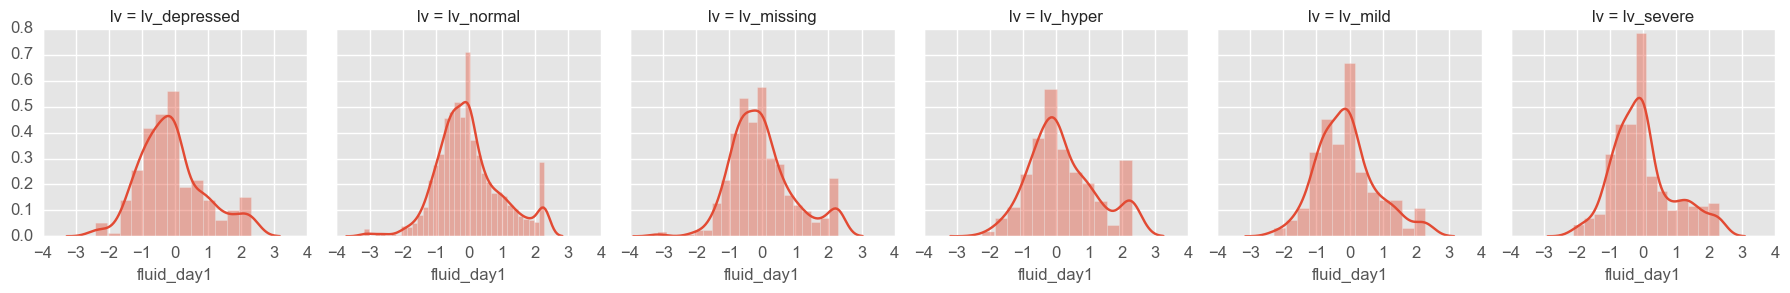

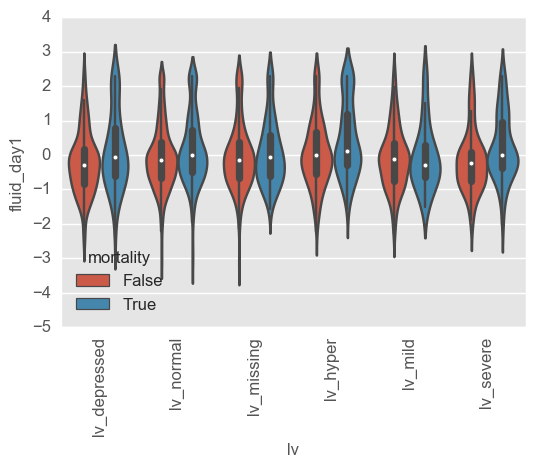

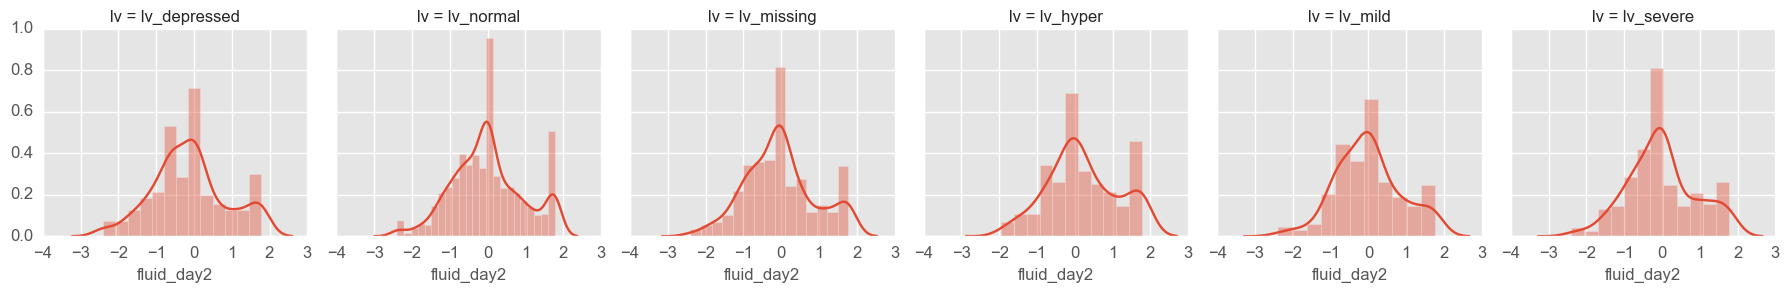

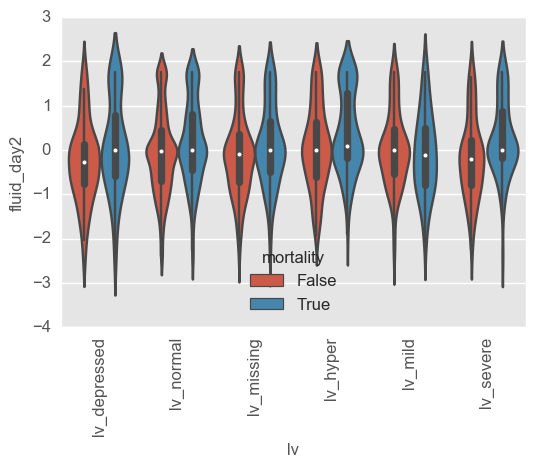

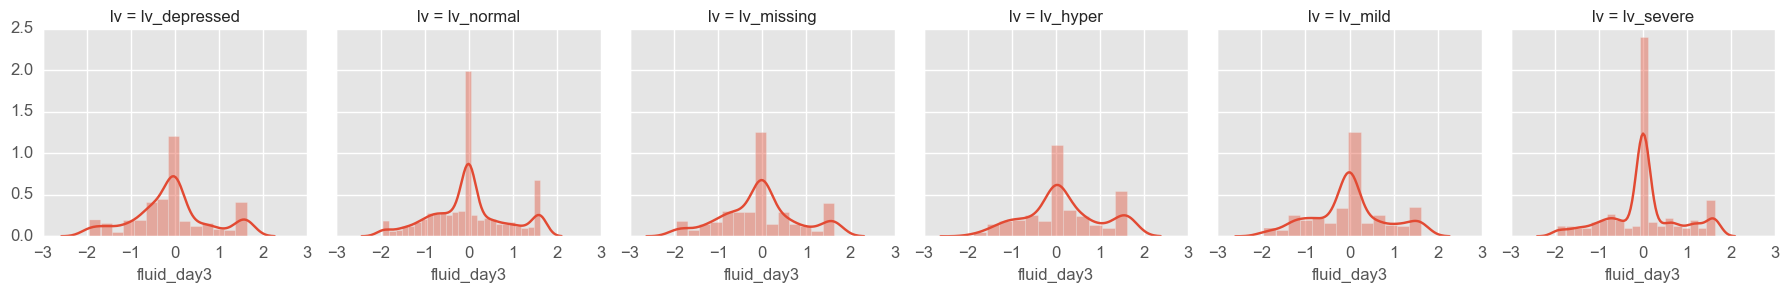

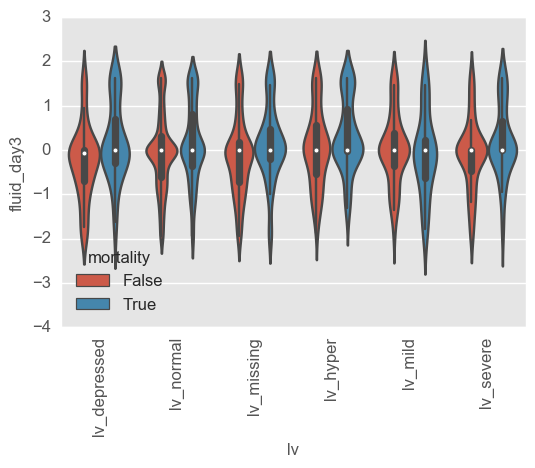

In [79]:
echo_fs = 'lv'
echo_features_ = echo_features[echo_fs] + ['{}_normal'.format(echo_fs), 'no_echo']
for fluid_fs in ['fluid_day1', 'fluid_day2', 'fluid_day3']: 

    inspect = X.copy()
    inspect['mortality'] = y
    inspect['no_echo'] = no_echo
    to_plot = inspect[['mortality', fluid_fs] + echo_features_].set_index(['mortality', fluid_fs]).idxmax(axis = 1).reset_index()
    to_plot.columns = ['mortality', fluid_fs, echo_fs]

    plt.figure()
    g = sns.FacetGrid(data = to_plot, col = echo_fs)
    g.map(sns.distplot, fluid_fs)
    #g = sns.violinplot(data = to_plot, x = echo_fs, y = fluid_fs)
    #g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    
    plt.figure()
    g = sns.violinplot(data = to_plot, x = echo_fs, hue = 'mortality', y = fluid_fs)
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    

## plm_htn

In [55]:
echo_fs = 'plm_htn'

for fluid_fs in ['fluid_day1', 'fluid_day2', 'fluid_day3']: 
    X_ = make_data(fluid_fs, echo_fs)
    X_ = pd.concat([X_, make_interactions(fluid_fs, echo_fs)], axis = 1)
    X_ = sm.add_constant(X_)
    
    logit = sm.Logit(y, X_)
    res = logit.fit()
    
    print(res.summary2(title = '{}:{}'.format(fluid_fs, echo_fs)))

Optimization terminated successfully.
         Current function value: 0.524583
         Iterations 7
                             fluid_day1:plm_htn
Model:                  Logit               Pseudo R-squared:    0.136      
Dependent Variable:     y                   AIC:                 3915.2236  
Date:                   2017-05-25 16:28    BIC:                 4064.3188  
No. Observations:       3686                Log-Likelihood:      -1933.6    
Df Model:               23                  LL-Null:             -2237.2    
Df Residuals:           3662                LLR p-value:         1.3968e-113
Converged:              1.0000              Scale:               1.0000     
No. Iterations:         7.0000                                              
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
con

## rvcav

In [56]:
echo_fs = 'rvcav'

for fluid_fs in ['fluid_day1', 'fluid_day2', 'fluid_day3']: 
    X_ = make_data(fluid_fs, echo_fs)
    X_ = pd.concat([X_, make_interactions(fluid_fs, echo_fs)], axis = 1)
    X_ = sm.add_constant(X_)
    
    logit = sm.Logit(y, X_)
    res = logit.fit()
    
    print(res.summary2(title = '{}:{}'.format(fluid_fs, echo_fs)))

Optimization terminated successfully.
         Current function value: 0.525619
         Iterations 7
                            fluid_day1:rvcav
Model:                 Logit              Pseudo R-squared:   0.134      
Dependent Variable:    y                  AIC:                3928.8608  
Date:                  2017-05-25 16:28   BIC:                4096.5928  
No. Observations:      3686               Log-Likelihood:     -1937.4    
Df Model:              26                 LL-Null:            -2237.2    
Df Residuals:          3659               LLR p-value:        7.2225e-110
Converged:             1.0000             Scale:              1.0000     
No. Iterations:        7.0000                                            
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
const                    -2.2822   0.15